##Clustering

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TFM/datasetSeleccionadasPreClustering.csv', decimal='.')

# Dataset con la capacidad de los estadios
stadium_capacity_df = pd.read_csv('/content/drive/MyDrive/TFM/stadium_capacity.csv', decimal='.')


In [ ]:
#Eliminacion promedios y columnas que no se van a utilizar
eliminacion_clumnas_menor_60 = ['id', 'home_clearances', 'home_fouls_conceded', 'home_offsides', 'home_tackles', 'away_clearances', 'away_fouls_conceded',
                                'away_offsides', 'away_tackles', 'clearances_avg_H', 'fouls_conceded_avg_H', 'offsides_avg_H', 'tackles_avg_H',
                                'fouls_conceded_avg_A', 'offsides_avg_A', 'tackles_avg_A']
df.drop(eliminacion_clumnas_menor_60, axis=1, inplace=True)

In [ ]:
import pandas as pd

df['points'] = df['result_match'].apply(lambda x: 3 if x == 0 else (1 if x == 1 else 0))

total_points = df.groupby('home_team')['points'].sum().reset_index()
total_points.rename(columns={'points': 'total_local_points'}, inplace=True)
total_points = total_points.sort_values(by='total_local_points', ascending=False)

total_points.to_csv('/content/drive/MyDrive/TFM/total_local_points.csv', index=False)
total_points.head()

,home_team,total_local_points
19,manchester city,504
20,manchester united,440
10,chelsea,435
1,arsenal,431
18,liverpool,428


In [ ]:
import pandas as pd

total_points = pd.read_csv('/content/drive/MyDrive/TFM/total_local_points.csv')

# Cargar el archivo stadium_capacity.csv con el separador adecuado
stadium_capacity = pd.read_csv('/content/drive/MyDrive/TFM/stadium_capacity.csv', sep=';', decimal='.')

merged_df = pd.merge(total_points, stadium_capacity, on='home_team', how='inner')

analysis_df = merged_df[['home_team', 'total_local_points', 'capacity']]
print(analysis_df.head())

# Análisis de correlación
correlation = analysis_df[['total_local_points', 'capacity']].corr()
print(correlation)

# Guardar el DataFrame de análisis en un archivo CSV
analysis_df.to_csv('/content/drive/MyDrive/TFM/analysis_local_points_vs_capacity.csv', index=False)


           home_team  total_local_points  capacity
0    manchester city                 504     55017
1  manchester united                 440     74879
2            chelsea                 435     40853
3            arsenal                 431     60704
4          liverpool                 428     60725
                    total_local_points  capacity
total_local_points            1.000000  0.739563
capacity                      0.739563  1.000000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

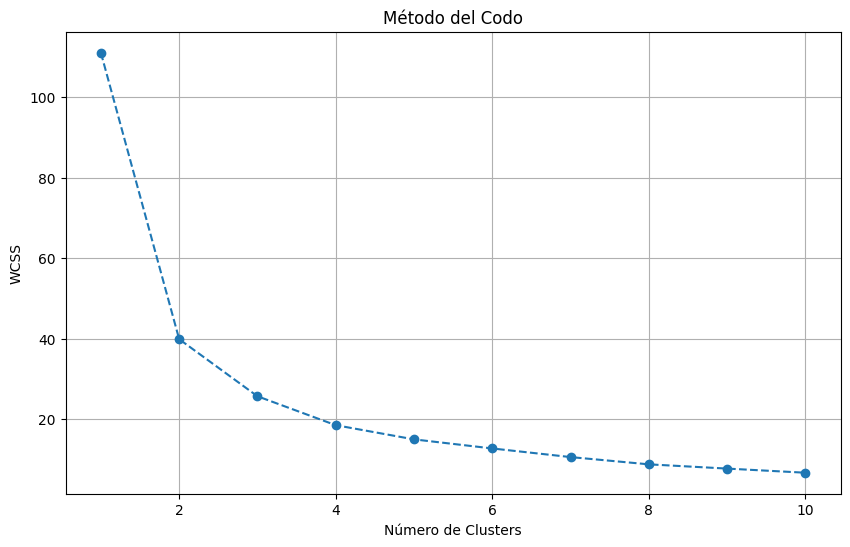

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.4142427506320142
         avg_points      capacity  games_played
cluster                                        
0          1.152857  28063.000000     36.928571
1          1.970000  56604.111111    199.111111
2          1.340000  28572.428571    125.785714


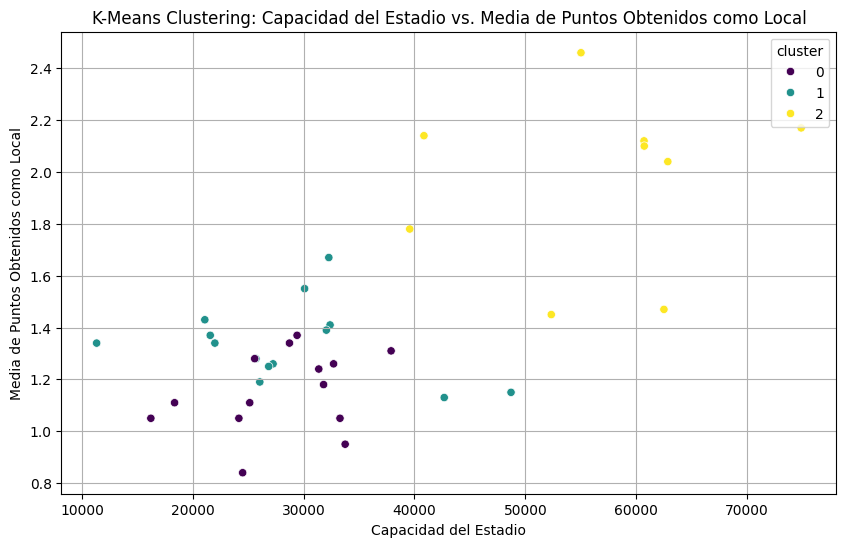

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = pd.read_csv('/content/drive/MyDrive/TFM/datasetSeleccionadasPreClustering.csv')

df_merged = pd.read_csv('/content/drive/MyDrive/TFM/analysis_local_points_vs_capacity.csv')

# Contar el número de partidos jugados como local para cada equipo
games_played = df['home_team'].value_counts().reset_index()
games_played.columns = ['home_team', 'games_played']

# Calcular la media de puntos por partido como local (avg_points)
total_points = df.groupby('home_team')['result_match'].apply(lambda x: (x == 0).sum() * 3 + (x == 1).sum()).reset_index()
total_points.columns = ['home_team', 'total_points']
total_points = total_points.merge(games_played, on='home_team')
total_points['avg_points'] = (total_points['total_points'] / total_points['games_played']).round(2)

# Fusionar el DataFrame de avg_points y games_played con df_merged
df_merged = df_merged.merge(total_points[['home_team', 'avg_points', 'games_played']], on='home_team', how='left')

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_merged[['avg_points', 'capacity', 'games_played']])

# Método Elbow
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

#K-Means con el número óptimo de clusters (3)
kmeans = KMeans(n_clusters=3, random_state=42)
df_merged['cluster'] = kmeans.fit_predict(scaled_df)

silhouette_avg = silhouette_score(scaled_df, df_merged['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Calcular la media de capacidad, avg_points y partidos jugados para cada cluster
cluster_means = df_merged.groupby('cluster')[['avg_points', 'capacity', 'games_played']].mean()
print(cluster_means)

# Ordenar los clusters por la media de capacidad, avg_points y juegos
cluster_means['impact'] = cluster_means['avg_points'] + cluster_means['capacity'] + cluster_means['games_played']
sorted_clusters = cluster_means.sort_values(by='impact', ascending=False).index

cluster_mapping = {sorted_clusters[i]: 2 - i for i in range(len(sorted_clusters))}
df_merged['cluster'] = df_merged['cluster'].map(cluster_mapping)

df_merged = df_merged.sort_values(['cluster', 'avg_points'], ascending=[False, False])

# Columnas relevantes para el CSV final
df_final = df_merged[['home_team', 'avg_points', 'games_played', 'capacity', 'cluster']]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='capacity', y='avg_points', hue='cluster', data=df_final, palette='viridis')
plt.title('K-Means Clustering: Capacidad del Estadio vs. Media de Puntos Obtenidos como Local')
plt.xlabel('Capacidad del Estadio')
plt.ylabel('Media de Puntos Obtenidos como Local')
plt.grid(True)
plt.show()

df_final.to_csv('/content/drive/MyDrive/TFM/clustered_analysis_avg_points_vs_capacity_sorted.csv', index=False)
